In [1]:
import pandas as pd
from everypolitician import EveryPolitician
from zodiac_sign import get_zodiac_sign

Read in countries and their legislatures

In [2]:
import urllib.request, json 
with urllib.request.urlopen("https://raw.githubusercontent.com/everypolitician/everypolitician-data/master/countries.json") as url:
    countries = json.loads(url.read().decode())

Read in country locations

In [3]:
locations = pd.read_csv('http://thedataalligator.com/wp-content/uploads/countries.csv', index_col=0)

# Data set from: https://www.kaggle.com/eidanch/counties-geographic-coordinates#countries.csv
# Derived from Google countries.csv: https://developers.google.com/public-data/docs/canonical/countries_csv
# CC BY 3.0

For every country that we have political data from, we determine the most commonly occurring zodiac sign.
We also determine the percentage of politicians who have this sign. 

In [4]:
country_loc_zodiac = {}
country_zodiac_list = {}
for c in countries:
    # Get geolocation for each country that we have political information for
    try:
        loc = (locations.loc[c['code']]['latitude'], locations.loc[c['code']]['longitude'])
    except:
        continue
    
    country = EveryPolitician().country(c['slug'])
    zodiac_signs = []
    # For countries with multiple legislative bodies, look at all of them
    for l in c['legislatures']:
        for p in country.legislature(l['slug']).popolo().persons:
            try:
                bd = p.birth_date
                # Only consider politicians for which we know an exact birthdate (no approximate dates)
                if bd.earliest_date == bd.latest_date:
                    zodiac_signs.append(get_zodiac_sign(bd.midpoint_date))
                else:
                    continue
            except:
                continue
    
    # Per country, determine the most common zodiac sign
    df = pd.DataFrame(zodiac_signs, columns=['zodiac_sign'])
    grouped = df.groupby(['zodiac_sign']).size()
    try:
        max_zodiac_sign = grouped.idxmax()
        max_zodiac_sign_count = grouped.max()
        country_loc_zodiac[c['name']] = {'location': loc,
                                         'most_common_zodiac': max_zodiac_sign, # The most common zodiac sign
                                         'count_most_common_zodiac': max_zodiac_sign_count, # Number of politicians with that zodiac sign
                                         'politicans_with_zodiac': len(zodiac_signs), # Number of all politicians we know a zodiac sign for
                                         'perc_most_common_zodiac': max_zodiac_sign_count/len(zodiac_signs) # Percentage of politicians who have most common zodiac sign
                                        }
        country_zodiac_list[c['name']] = zodiac_signs
    except:
        continue

## Show zodiac sign distribution for a country

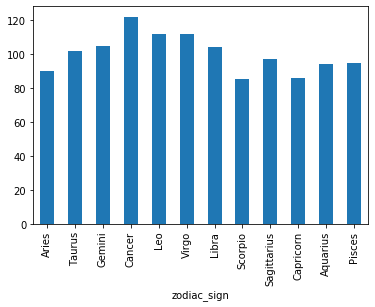

In [6]:
country = 'Italy'

s = pd.DataFrame(country_zodiac_list[country], columns=['zodiac_sign'])
zodiac_count = s.groupby(['zodiac_sign']).size()

zodiac_count.loc[['Aries', 'Taurus', 'Gemini', 'Cancer', 'Leo', 'Virgo', 'Libra', 'Scorpio', 
                'Sagittarius', 'Capricorn', 'Aquarius', 'Pisces']].plot(kind='bar', x='zodiac_sign')

It's not completely uniform, is it? ;)
## In the 1st House
Let's now map the most common astrological sign to each country. It definitely means something. Definitely. Something.

In [12]:
import folium
geo_map = folium.Map(location=[50.85, 15.35], 
                     tiles='https://{s}.basemaps.cartocdn.com/rastertiles/voyager/{z}/{x}/{y}{r}.png',
                     attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
                     zoom_start=4)

zodiac_icon = {'Scorpio': '001-scorpio',
              'Aries': '002-aries',
              'Capricorn': '003-capricorn',
              'Leo': '004-leo',
              'Libra': '005-libra',
              'Gemini': '006-gemini',
              'Taurus': '007-taurus',
              'Sagittarius': '008-sagittarius',
              'Pisces': '009-pisces',
              'Virgo': '010-virgo',
              'Aquarius': '011-aquarius',
              'Cancer': '012-cancer'}

for country in country_loc_zodiac:
    loc = list(country_loc_zodiac[country]['location'])
    icon = zodiac_icon[country_loc_zodiac[country]['most_common_zodiac']]
    icon = folium.features.CustomIcon('http://thedataalligator.com/wp-content/uploads/432117-zodiac-signs/png/' + zodiac_icon[country_loc_zodiac[country]['most_common_zodiac']] + '.png',
                                      icon_size=(30,30))
    folium.Marker(loc,
                  icon=icon,
                  popup=country_loc_zodiac[country]['most_common_zodiac'] + ' (' + "{:.2%}".format(country_loc_zodiac[country]['perc_most_common_zodiac']) + ')'
                  ).add_to(geo_map)
geo_map